In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"
device_ids = [0, 1, 2, 3]
import os.path
from datetime import datetime
from time import time
from torch import nn as nn
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm

import optuna
from optuna.trial import TrialState
from optuna.integration.wandb import WeightsAndBiasesCallback

import torch
import numpy as np
from tqdm import tqdm
import pandas as pd

from dragonnet import DragonNet

In [2]:
%time train_df =  pd.read_pickle('../../train_data_0205.pkl')
%time test_df =  pd.read_pickle('../../test_data_0205.pkl')

CPU times: user 5.59 s, sys: 8.13 s, total: 13.7 s
Wall time: 13.8 s
CPU times: user 2.71 s, sys: 3.63 s, total: 6.34 s
Wall time: 6.37 s


In [3]:
in_features = ['meta_bitrate_diff', 'wifi_play_ratio', 'playing_time_funny', 'w3_app_use_duration_ks', 'fr_nn_vnus', 'is_photo_author_ks', 'nr_nn_diff_abs', 'w0_app_use_duration_ks', 'meta_bitrate_diff_abs', 'is_live_author', 
               'nr_nn_fast', 'playing_time_sport', 'is_active_7d_ks', 'video_ratio', 'blocky_probability_new', 'mbps_pct30_avg', 'low_catg_ratio', 'upload_days_num_30d', 'playing_time_travel', 'playing_time_animal', 
               'follow_cnt', 'fr_nn_diff_abs', 'meta_bitrate_vnus', 'friend_user_num', 'w1_active_day_ks', 'finish_played_ratio', 'play_cnt_11', 'sum_finish_play_ratio', 'playing_time_star', 'mbps_avg', 'playing_dur_15', 
               'nr_nn_vnus', 'live_days', 'general_score', 'inter_complexity', 'intra_complexity', 'playing_time_news', 'play_cnt_13', 'live_minutes', 'upload_cnt', 'nr_nn_diff', 'mbps_pct50_avg', 'playing_dur_17', 'playing_time_life', 
               'playing_time_game', 'mobile_mbps_overall', 'std_mbps_avg', 'mbps_pct90_avg', 'mbps_pct10_avg', 'playing_dur_14', 'playing_dur_11', '4g_play_ratio', 'playing_time_health', 'playing_dur_16', 'play_cnt_17', 'high_catg_ratio', 
               'playing_time_child', 'follow_user_num', 'upload_photo_num_30d', 'playing_time_rural', 'video_minutes', 'fr_nn_fast', 'playing_time_car', 'memory_kuaishou_score', 'playing_time_religion', 'fr_nn_diff', 
               'play_cnt_15', 'month_app_use_duration_ks', 'play_cnt', 'is_install_xigua', 'total_minutes', 'playing_dur_13', 'mbps_overall', 'play_cnt_16', 'playing_time_3c', 'avg_month_app_use_duration_ks', 
               'playing_time_knowledge', 'play_cnt_14', 'month_active_day_ks', 'playing_time_null', 'wifi_mbps_avg', 'playing_dur', 'playing_time_outfit', 'live_ratio', 'play_cnt_12', '5g_play_ratio', 'w3_active_day_ks', 
               'w1_app_use_duration_ks', 'playing_time_beauty', 'blur_probability_new', 'w2_app_use_duration_ks', 'meta_bitrate_fast', 'playing_time_food', 'w0_active_day_ks', 'playing_time_makeup', 'playing_time_movie', 
               'playing_time_emo', 'playing_time_dance', 'mid_catg_ratio', 'playing_time_carton', 'is_install_douyin', '720p_bitrate_mean', 'playing_dur_12', 'playing_time_military', 'w2_active_day_ks', 'io_kuaishou_score', 
               'playing_time_house', 'active_30d_cnt', 'p_app_platform', 'user_active_degree_ks', 'life_time_ks', 'active_7d_degree', 'user_active_degree', 'gender', 'age_segment', 'fre_community_type', 'fre_city_level', 
               'fre_sourth_north', 'fre_region', 'mod_price_range', 'reg_channel', 'fans_user_num_range', 'author_life_cycle']
categorical_features = ['p_app_platform', 'user_active_degree_ks', 'life_time_ks', 'active_7d_degree', 'user_active_degree', 'gender', 'age_segment', 'fre_community_type', 'fre_city_level', 'fre_sourth_north', 'fre_region', 
                'mod_price_range', 'reg_channel', 'fans_user_num_range', 'author_life_cycle']
label_feature = ['label_log']
treatment_feature = ['groupId']

In [4]:
X_train = train_df[in_features].values
y_train = train_df[label_feature].values
t_train = train_df[treatment_feature].values
X_test = test_df[in_features].values
y_test = test_df[label_feature].values
t_test = test_df[treatment_feature].values

In [5]:
def get_new_df(df, uplift_val, treatment_feature, label_feature):
    new_df = pd.DataFrame(columns = [treatment_feature[0], label_feature[0], uplift_val])
    new_df[treatment_feature[0]] = df[treatment_feature[0]]
    new_df[label_feature[0]] = df[label_feature[0]]
    new_df[uplift_val] = df[uplift_val]
    return new_df
    
def auuc_metric(data, uplift_val, bucket_num, treatment_feature, label_feature, if_return = True, final_test = False):
    # print('label_feature',label_feature)
    new_data = get_new_df(data, uplift_val, treatment_feature, label_feature)
    if final_test:
        del data
    new_data = new_data.sort_values(by=uplift_val, ascending = False)
    # print(bucket_num)
    new_data['bucket'] = pd.qcut(-new_data[uplift_val], bucket_num, labels=False, duplicates='drop')
    # print('====计算完毕====')
    # print('====生成随机数====')
    new_data = new_data.sort_values(by=treatment_feature)
    
    l0, l1 = new_data.loc[new_data[treatment_feature[0]]==0], new_data.loc[new_data[treatment_feature[0]]==1]
    mean0, mean1 = l0[label_feature].values.mean(), l1[label_feature].values.mean()
    print('treatment = 0:', mean0, 'treatment = 1:', mean1)
    r0, r1 = (np.random.rand(len(l0)) - 0.5)/100000 + mean0, (np.random.rand(len(l1)) - 0.5)/100000 + mean1
    print(type(r0))
    new_data['random'] = r0.tolist() + r1.tolist()
    bucket_diff = []
    # print(set(new_data.bucket))
    # print('=========')
    for i in set(new_data.bucket):
        mean_treat = np.mean(new_data.loc[(new_data.bucket == i)&(new_data[treatment_feature[0]] == 1), label_feature].values)
        mean_control = np.mean(new_data.loc[(new_data.bucket == i)&(new_data[treatment_feature[0]] == 0), label_feature].values)
        bucket_diff.append(mean_treat / mean_control - 1)
    plt.ylabel('diff of '+label_feature[0])
    plt.bar(range(len(bucket_diff)),bucket_diff)
    plt.show()
    
    res, population, rand_res, bucket_len = [], [], [], []
    for i in np.arange(0, len(set(new_data.bucket)), 1):
        dbucket = new_data.loc[new_data.bucket <= i]
        db_base = dbucket.loc[dbucket[treatment_feature[0]] == 0]
        db_exp = dbucket.loc[dbucket[treatment_feature[0]] == 1]
        cumugain = (db_exp[label_feature].mean() / db_base[label_feature].mean() - 1) * (len(db_base) + len(db_exp))
        cumu_random = (db_exp['random'].mean() / db_base['random'].mean()- 1 ) * (len(db_base) + len(db_exp))
        population.append(len(db_base) + len(db_exp))
        bucket_len.append(len(new_data[new_data.bucket == i]))
        res.append(cumugain)
        rand_res.append(cumu_random)
    rand_res[-1] = res[-1]
    cumuGain = pd.DataFrame({'cumuGain': res,
                             'population': population,
                             'percent': np.arange(1 / len(set(new_data.bucket)), 1 + 1 / len(set(new_data.bucket)),
                                                  1 / len(set(new_data.bucket))),
                             'random': rand_res})
    
    # 归一化 将值框定在[0，1]之间
    cumugain = cumuGain['cumuGain']
    gap0 = cumugain.iloc[-1].values
    cumugain = [(i) / abs(gap0) for i in cumugain]

    cumu_random = cumuGain['random']
    gap = cumu_random.iloc[-1]
    cumu_random = [(i) / abs(gap) for i in cumu_random]
    
    plt.plot(np.append(0,(np.array(population))/max(population)), np.append(0,cumugain), marker='*', label='pred')
    plt.plot(np.append(0,(np.array(population))/max(population)), np.append(0,cumu_random), marker='*', label='random')
    plt.grid(linestyle='--')
    plt.xlabel('Percent')
    plt.ylabel('Uplift')
    plt.legend()
    plt.show()
    
    # 近似计算cumugain函数和x轴围成的曲线下面积，也就是auuc
    auuc_value, rand = np.trapz(np.append(0, cumugain),np.append(0, (np.array(population))/max(population))),\
                                np.trapz(np.append(0, cumu_random),np.append(0, (np.array(population))/max(population)))
    auuc_value = auuc_value - rand
    spearmanr_value = -scipy.stats.spearmanr(bucket_diff, list(set(new_data.bucket)))[0]
    # print(cumugain, np.array(population)/max(population))
    if gap0 < 0: 
        auuc_value, rand = np.trapz([i + 1 for i in np.append(0, cumugain)], np.append(0,(np.array(population))/max(population))),\
                                    np.trapz([i + 1 for i in np.append(0, cumu_random)], np.append(0,(np.array(population))/max(population)))
        auuc_value = auuc_value - rand
    print('auuc score:', auuc_value, 'random score:', rand)
    print('spearmanr:', spearmanr_value)
    if if_return == True:return data
    else: return auuc_value

In [6]:
def objective(trial):
    params = {
        'epochs': trial.suggest_int('epochs', 40, 70),
        'shared_hidden': trial.suggest_int('shared_hidden', 100, 300),
        'outcome_hidden': trial.suggest_int('outcome_hidden', 50, 150),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-3),
        'alpha': trial.suggest_float('alpha', 0.5, 1),
        'beta': trial.suggest_float('beta', 0.5,1),
    }
    
    print("epochs:",params["epochs"])
    print("shared_hidden:",params["shared_hidden"])
    print("outcome_hidden:",params["outcome_hidden"])
    print("learning_rate:",params["learning_rate"])
    print("alpha:",params["alpha"])
    print("beta:",params["beta"])
        
    model = DragonNet(input_dim=X_train.shape[1],shared_hidden=params["shared_hidden"],outcome_hidden=params["outcome_hidden"],
                     alpha=params["alpha"],beta=params["beta"],epochs=params["epochs"])    

    start = time()
    model.fit(X_train, y_train, t_train)
    print(f"Time for realization: {time() - start:.2f}s")

    y0_pred, y1_pred, t_pred, _ = model.predict(X_test)
    y0_pred[y0_pred<0]=0
    y1_pred[y1_pred<0]=0
    test_df['target_dif'] = y1_pred - y0_pred

    auuc_score = auuc_metric(test_df,'target_dif', 5, treatment_feature, label_feature, if_return = False)
    
    return auuc_score

In [7]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

[I 2023-04-22 00:09:30,186] A new study created in memory with name: no-name-f4c91024-4fc5-4db2-a7c7-24e714285f53


epochs: 60
shared_hidden: 250
outcome_hidden: 91
learning_rate: 0.0001302603692989724
alpha: 0.6864896315855842
beta: 0.6459167750846957
epoch: 0--------- train_loss: 90579419136.0
epoch: 1--------- train_loss: 1429260337152.0
epoch: 2--------- train_loss: 1002094592000.0
epoch: 3--------- train_loss: 2936049238016.0
epoch: 7--------- train_loss: 1571374976.0
epoch: 8--------- train_loss: 1505065216.0
epoch: 9--------- train_loss: 1357171712.0
epoch: 10--------- train_loss: 1230672128.0
epoch: 11--------- train_loss: 1026869248.0
epoch: 12--------- train_loss: 1069875968.0
epoch: 13--------- train_loss: 25101717504.0
epoch: 14--------- train_loss: 41039269888.0
epoch: 15--------- train_loss: 326516998144.0
epoch: 16--------- train_loss: 13180858368.0
epoch: 17--------- train_loss: 2040392448.0
epoch: 18--------- train_loss: 474959552.0
epoch: 19--------- train_loss: 1271880576.0
epoch: 20--------- train_loss: 701565952.0
epoch: 21--------- train_loss: 425131648.0
epoch: 22--------- tra

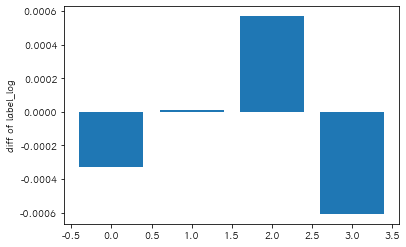

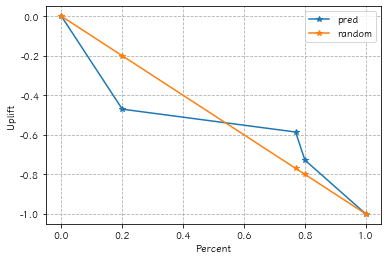

[I 2023-04-22 00:49:03,601] Trial 0 finished with value: -0.04045855251443764 and parameters: {'epochs': 60, 'shared_hidden': 250, 'outcome_hidden': 91, 'learning_rate': 0.0001302603692989724, 'alpha': 0.6864896315855842, 'beta': 0.6459167750846957}. Best is trial 0 with value: -0.04045855251443764.


auuc score: -0.04045855251443764 random score: 0.49999909319300384
spearmanr: 0.19999999999999998
epochs: 45
shared_hidden: 262
outcome_hidden: 119
learning_rate: 0.0005720164583860175
alpha: 0.9919772585903566
beta: 0.8288152850738633
epoch: 0--------- train_loss: 6239086968832.0
epoch: 1--------- train_loss: 1424254208.0
epoch: 2--------- train_loss: 25182619648.0
epoch: 3--------- train_loss: 1252481152.0
epoch: 4--------- train_loss: 2298335232.0
epoch: 5--------- train_loss: 4954437632.0
epoch: 6--------- train_loss: 728598464.0
epoch: 7--------- train_loss: 656002688.0
epoch: 8--------- train_loss: 543741312.0
epoch: 9--------- train_loss: 514695488.0
epoch: 10--------- train_loss: 3424384512.0
epoch: 11--------- train_loss: 26393030656.0
epoch: 12--------- train_loss: 730818432.0
epoch: 13--------- train_loss: 482222848.0
epoch: 14--------- train_loss: 539400576.0
epoch: 15--------- train_loss: 387605568.0
epoch: 16--------- train_loss: 773931456.0
epoch: 17--------- train_loss:

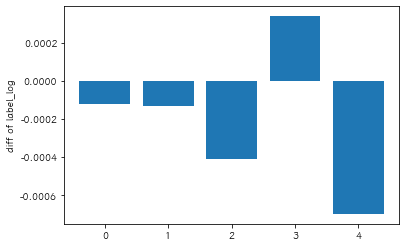

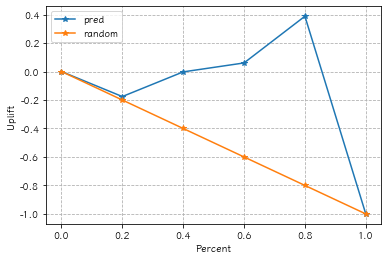

[I 2023-04-22 01:17:22,995] Trial 1 finished with value: 0.45390604053079386 and parameters: {'epochs': 45, 'shared_hidden': 262, 'outcome_hidden': 119, 'learning_rate': 0.0005720164583860175, 'alpha': 0.9919772585903566, 'beta': 0.8288152850738633}. Best is trial 1 with value: 0.45390604053079386.


auuc score: 0.45390604053079386 random score: 0.5000001244671488
spearmanr: 0.39999999999999997
epochs: 66
shared_hidden: 200
outcome_hidden: 58
learning_rate: 0.0009730135952293306
alpha: 0.9977670114599491
beta: 0.5050835949187793
epoch: 0--------- train_loss: 13691009368064.0
epoch: 1--------- train_loss: 46261264384.0
epoch: 2--------- train_loss: 14811275264.0
epoch: 3--------- train_loss: 3664772608.0
epoch: 4--------- train_loss: 14057067520.0
epoch: 5--------- train_loss: 6630126592.0
epoch: 6--------- train_loss: 7908272128.0
epoch: 7--------- train_loss: 3323679232.0
epoch: 8--------- train_loss: 3672498688.0
epoch: 9--------- train_loss: 3078404608.0
epoch: 10--------- train_loss: 3146894080.0
epoch: 11--------- train_loss: 2024032512.0
epoch: 12--------- train_loss: 2314167040.0
epoch: 13--------- train_loss: 3578942464.0
epoch: 14--------- train_loss: 1940978688.0
epoch: 15--------- train_loss: 2045571328.0
epoch: 16--------- train_loss: 1463673728.0
epoch: 17--------- tra

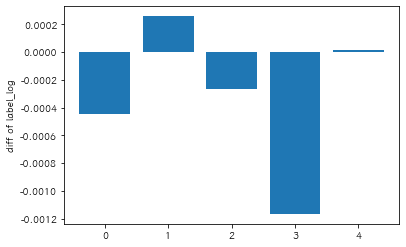

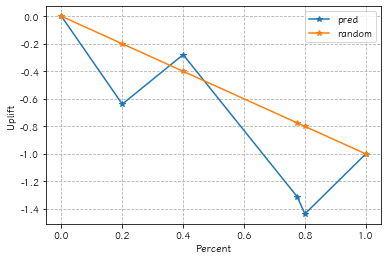

[I 2023-04-22 01:49:23,999] Trial 2 finished with value: -0.23186385433078888 and parameters: {'epochs': 66, 'shared_hidden': 200, 'outcome_hidden': 58, 'learning_rate': 0.0009730135952293306, 'alpha': 0.9977670114599491, 'beta': 0.5050835949187793}. Best is trial 1 with value: 0.45390604053079386.


auuc score: -0.23186385433078888 random score: 0.5000014449829917
spearmanr: -0.0
epochs: 67
shared_hidden: 243
outcome_hidden: 51
learning_rate: 0.0009250872132914794
alpha: 0.9297132303059255
beta: 0.6270910698022667
epoch: 0--------- train_loss: 18574911471616.0
epoch: 1--------- train_loss: 297366781952.0
epoch: 2--------- train_loss: 4770408448.0
epoch: 3--------- train_loss: 3821473024.0
epoch: 4--------- train_loss: 2653762304.0
epoch: 5--------- train_loss: 1779546880.0
epoch: 6--------- train_loss: 916736640.0
epoch: 7--------- train_loss: 721782144.0
epoch: 8--------- train_loss: 1160887296.0
epoch: 9--------- train_loss: 533214720.0
epoch: 10--------- train_loss: 443756992.0
epoch: 11--------- train_loss: 776180864.0
epoch: 12--------- train_loss: 4504755200.0
epoch: 13--------- train_loss: 663964800.0
epoch: 14--------- train_loss: 475565248.0
epoch: 15--------- train_loss: 431136832.0
epoch: 16--------- train_loss: 803473216.0
epoch: 17--------- train_loss: 2426891776.0
ep

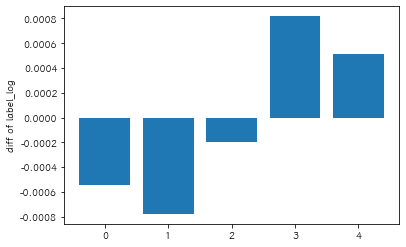

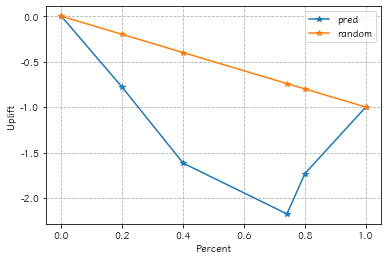

[I 2023-04-22 02:26:22,106] Trial 3 finished with value: -0.853290517978599 and parameters: {'epochs': 67, 'shared_hidden': 243, 'outcome_hidden': 51, 'learning_rate': 0.0009250872132914794, 'alpha': 0.9297132303059255, 'beta': 0.6270910698022667}. Best is trial 1 with value: 0.45390604053079386.


auuc score: -0.853290517978599 random score: 0.5000001436784544
spearmanr: -0.7999999999999999
epochs: 68
shared_hidden: 288
outcome_hidden: 65
learning_rate: 0.0006697873907442492
alpha: 0.6982249912641083
beta: 0.5666534868339312
epoch: 0--------- train_loss: 4485631967232.0
epoch: 1--------- train_loss: 10664418476032.0
epoch: 2--------- train_loss: 234571431936.0
epoch: 3--------- train_loss: 526216724480.0
epoch: 4--------- train_loss: 6742967296.0
epoch: 5--------- train_loss: 8910333952.0
epoch: 6--------- train_loss: 3692294656.0
epoch: 7--------- train_loss: 1905647616.0
epoch: 8--------- train_loss: 1556345088.0
epoch: 9--------- train_loss: 1479456128.0
epoch: 10--------- train_loss: 9953071104.0
epoch: 11--------- train_loss: 3623233792.0
epoch: 12--------- train_loss: 1198115712.0
epoch: 13--------- train_loss: 960245376.0
epoch: 14--------- train_loss: 849580672.0
epoch: 15--------- train_loss: 999232064.0
epoch: 16--------- train_loss: 1309708544.0
epoch: 17--------- tra

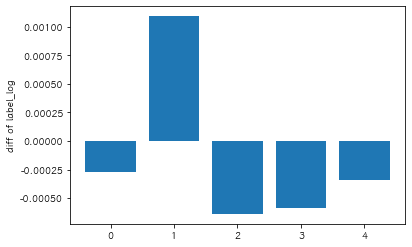

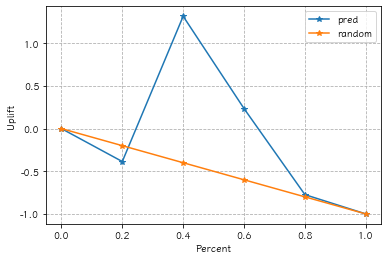

[I 2023-04-22 03:11:52,305] Trial 4 finished with value: 0.4783368169532736 and parameters: {'epochs': 68, 'shared_hidden': 288, 'outcome_hidden': 65, 'learning_rate': 0.0006697873907442492, 'alpha': 0.6982249912641083, 'beta': 0.5666534868339312}. Best is trial 4 with value: 0.4783368169532736.


auuc score: 0.4783368169532736 random score: 0.49999967530533224
spearmanr: 0.49999999999999994
epochs: 64
shared_hidden: 217
outcome_hidden: 88
learning_rate: 0.0008318810776943118
alpha: 0.7565125109148634
beta: 0.5474008256799776
epoch: 0--------- train_loss: 18834061312.0
epoch: 1--------- train_loss: 37628715008.0
epoch: 2--------- train_loss: 18808188928.0
epoch: 3--------- train_loss: 104694071296.0
epoch: 4--------- train_loss: 2054930432.0
epoch: 5--------- train_loss: 2973816832.0
epoch: 6--------- train_loss: 1553715200.0
epoch: 7--------- train_loss: 1334306816.0
epoch: 8--------- train_loss: 1523534080.0
epoch: 9--------- train_loss: 1289919232.0
epoch: 10--------- train_loss: 1257637760.0
epoch: 11--------- train_loss: 810227859456.0
epoch: 12--------- train_loss: 3462027008.0
epoch: 13--------- train_loss: 390039808.0
epoch: 14--------- train_loss: 367467232.0
epoch: 15--------- train_loss: 325016384.0
epoch: 16--------- train_loss: 314870624.0
epoch: 17--------- train_l

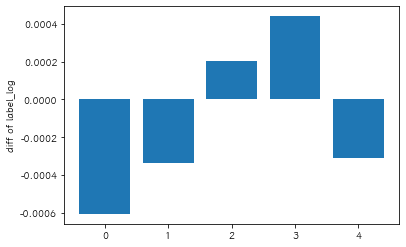

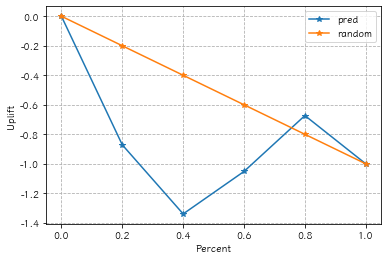

[I 2023-04-22 03:52:32,515] Trial 5 finished with value: -0.3870992823608594 and parameters: {'epochs': 64, 'shared_hidden': 217, 'outcome_hidden': 88, 'learning_rate': 0.0008318810776943118, 'alpha': 0.7565125109148634, 'beta': 0.5474008256799776}. Best is trial 4 with value: 0.4783368169532736.


auuc score: -0.3870992823608594 random score: 0.5000003477145389
spearmanr: -0.7
epochs: 47
shared_hidden: 150
outcome_hidden: 112
learning_rate: 0.0006881755928567775
alpha: 0.5652119226675887
beta: 0.846822143861399
epoch: 0--------- train_loss: 38295961600.0
epoch: 1--------- train_loss: 394777460736.0
epoch: 2--------- train_loss: 13038609408.0
epoch: 3--------- train_loss: 2432789504.0
epoch: 4--------- train_loss: 4652124160.0
epoch: 5--------- train_loss: 1792100352.0
epoch: 6--------- train_loss: 2334015744.0
epoch: 7--------- train_loss: 1357745920.0
epoch: 8--------- train_loss: 1689914240.0
epoch: 9--------- train_loss: 1299096832.0
epoch: 10--------- train_loss: 6808337920.0
epoch: 11--------- train_loss: 55167492096.0
epoch: 12--------- train_loss: 3215933952.0
epoch: 13--------- train_loss: 2086864000.0
epoch: 14--------- train_loss: 2133703936.0
epoch: 15--------- train_loss: 1435146752.0
epoch: 16--------- train_loss: 2046137856.0
epoch: 17--------- train_loss: 88316395

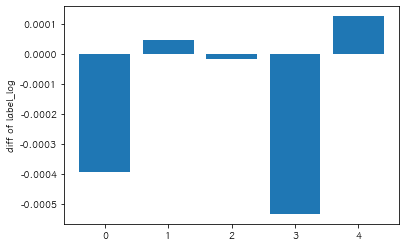

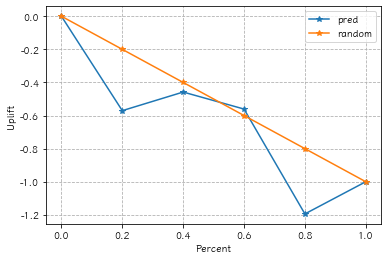

[I 2023-04-22 04:16:10,232] Trial 6 finished with value: -0.15678729339394432 and parameters: {'epochs': 47, 'shared_hidden': 150, 'outcome_hidden': 112, 'learning_rate': 0.0006881755928567775, 'alpha': 0.5652119226675887, 'beta': 0.846822143861399}. Best is trial 4 with value: 0.4783368169532736.


auuc score: -0.15678729339394432 random score: 0.49999961347540933
spearmanr: -0.3
epochs: 48
shared_hidden: 131
outcome_hidden: 121
learning_rate: 0.00038500709169360435
alpha: 0.6944451328249424
beta: 0.7934824200788531
epoch: 0--------- train_loss: 16049592336384.0
epoch: 1--------- train_loss: 8634170368.0
epoch: 2--------- train_loss: 3010202112.0
epoch: 3--------- train_loss: 864623744.0
epoch: 4--------- train_loss: 685345600.0
epoch: 5--------- train_loss: 514826624.0
epoch: 6--------- train_loss: 470194400.0
epoch: 7--------- train_loss: 435550432.0
epoch: 8--------- train_loss: 509053184.0
epoch: 9--------- train_loss: 506259200.0
epoch: 10--------- train_loss: 433107072.0
epoch: 11--------- train_loss: 541438848.0
epoch: 12--------- train_loss: 389801152.0
epoch: 13--------- train_loss: 360166816.0
epoch: 14--------- train_loss: 324579648.0
epoch: 15--------- train_loss: 428482048.0
epoch: 16--------- train_loss: 306941088.0
epoch: 17--------- train_loss: 297217856.0
epoch: 

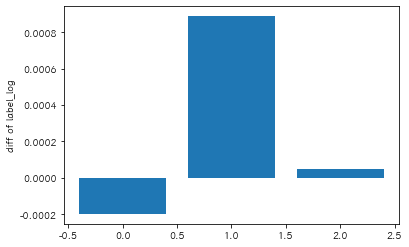

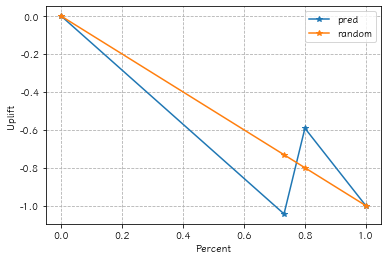

[I 2023-04-22 04:40:24,236] Trial 7 finished with value: -0.09694107200932839 and parameters: {'epochs': 48, 'shared_hidden': 131, 'outcome_hidden': 121, 'learning_rate': 0.00038500709169360435, 'alpha': 0.6944451328249424, 'beta': 0.7934824200788531}. Best is trial 4 with value: 0.4783368169532736.


auuc score: -0.09694107200932839 random score: 0.4999979718123845
spearmanr: -0.5
epochs: 62
shared_hidden: 292
outcome_hidden: 140
learning_rate: 0.0002605733972974236
alpha: 0.7591771100292393
beta: 0.9154074967398671
epoch: 0--------- train_loss: 1068885344256.0
epoch: 1--------- train_loss: 6109589504.0
epoch: 2--------- train_loss: 5085713408.0
epoch: 3--------- train_loss: 2892336640.0
epoch: 4--------- train_loss: 1325438720.0
epoch: 5--------- train_loss: 940783232.0
epoch: 6--------- train_loss: 571363712.0
epoch: 7--------- train_loss: 1381583360.0
epoch: 8--------- train_loss: 570762880.0
epoch: 9--------- train_loss: 1297427200.0
epoch: 10--------- train_loss: 683809792.0
epoch: 11--------- train_loss: 628635648.0
epoch: 12--------- train_loss: 1172141056.0
epoch: 13--------- train_loss: 1837821440.0
epoch: 14--------- train_loss: 14030071808.0
epoch: 15--------- train_loss: 28094676992.0
epoch: 16--------- train_loss: 13557327872.0
epoch: 17--------- train_loss: 1431791411

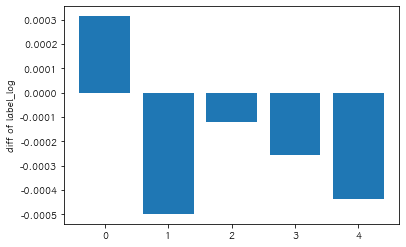

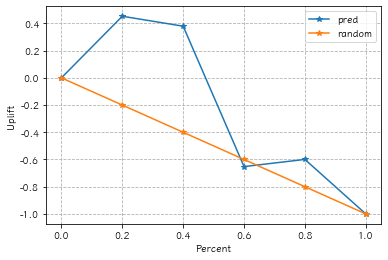

[I 2023-04-22 05:36:29,171] Trial 8 finished with value: 0.3161588073786926 and parameters: {'epochs': 62, 'shared_hidden': 292, 'outcome_hidden': 140, 'learning_rate': 0.0002605733972974236, 'alpha': 0.7591771100292393, 'beta': 0.9154074967398671}. Best is trial 4 with value: 0.4783368169532736.


auuc score: 0.3161588073786926 random score: 0.4999992997045618
spearmanr: 0.39999999999999997
epochs: 51
shared_hidden: 253
outcome_hidden: 91
learning_rate: 2.9371331971011326e-05
alpha: 0.5875062114989464
beta: 0.6330765795684175
epoch: 0--------- train_loss: 45797051727872.0
epoch: 1--------- train_loss: 728097554432.0
epoch: 2--------- train_loss: 3022763264.0
epoch: 3--------- train_loss: 2064595200.0
epoch: 4--------- train_loss: 1629126912.0
epoch: 5--------- train_loss: 2999716096.0
epoch: 6--------- train_loss: 977492480.0
epoch: 7--------- train_loss: 870809856.0
epoch: 8--------- train_loss: 958873216.0
epoch: 9--------- train_loss: 924679296.0
epoch: 10--------- train_loss: 24377962496.0
epoch: 11--------- train_loss: 4688065536.0
epoch: 12--------- train_loss: 1028222848.0
epoch: 13--------- train_loss: 1057252608.0
epoch: 14--------- train_loss: 1132489984.0
epoch: 15--------- train_loss: 718521280.0
epoch: 16--------- train_loss: 647260800.0
epoch: 17--------- train_los

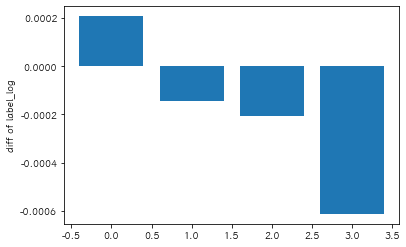

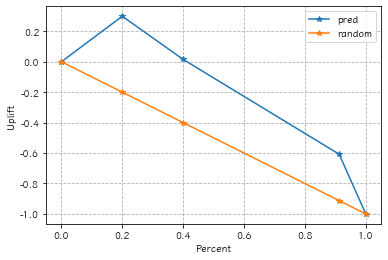

[I 2023-04-22 06:16:03,718] Trial 9 finished with value: 0.3391368698503968 and parameters: {'epochs': 51, 'shared_hidden': 253, 'outcome_hidden': 91, 'learning_rate': 2.9371331971011326e-05, 'alpha': 0.5875062114989464, 'beta': 0.6330765795684175}. Best is trial 4 with value: 0.4783368169532736.


auuc score: 0.3391368698503968 random score: 0.4999992733762252
spearmanr: 1.0
epochs: 56
shared_hidden: 300
outcome_hidden: 70
learning_rate: 0.0004859826927538711
alpha: 0.8342514499545175
beta: 0.9923969587908827
epoch: 0--------- train_loss: 421543182336.0
epoch: 1--------- train_loss: 805238210560.0
epoch: 2--------- train_loss: 72612823040.0
epoch: 3--------- train_loss: 30876147712.0
epoch: 4--------- train_loss: 3503755264.0
epoch: 5--------- train_loss: 2319230464.0
epoch: 6--------- train_loss: 4793177088.0
epoch: 7--------- train_loss: 2952880128.0
epoch: 8--------- train_loss: 2148448000.0
epoch: 9--------- train_loss: 1866503808.0
epoch: 10--------- train_loss: 1705648128.0
epoch: 11--------- train_loss: 1555617920.0
epoch: 12--------- train_loss: 2053097984.0
epoch: 13--------- train_loss: 1930087936.0
epoch: 14--------- train_loss: 4197505280.0
epoch: 15--------- train_loss: 2248854784.0
epoch: 16--------- train_loss: 3535063040.0
epoch: 17--------- train_loss: 723213670

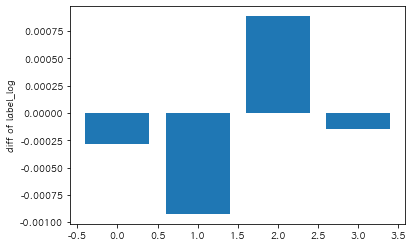

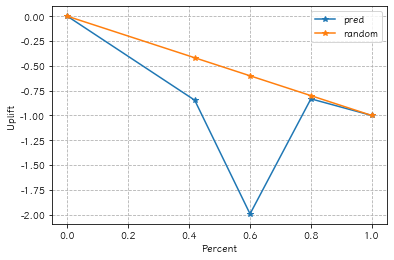

[I 2023-04-22 07:00:43,826] Trial 10 finished with value: -0.4004197882488289 and parameters: {'epochs': 56, 'shared_hidden': 300, 'outcome_hidden': 70, 'learning_rate': 0.0004859826927538711, 'alpha': 0.8342514499545175, 'beta': 0.9923969587908827}. Best is trial 4 with value: 0.4783368169532736.


auuc score: -0.4004197882488289 random score: 0.4999975552467474
spearmanr: -0.6000000000000001
epochs: 40
shared_hidden: 274
outcome_hidden: 149
learning_rate: 0.0006547872827516483
alpha: 0.861334607343075
beta: 0.763846480299527
epoch: 0--------- train_loss: 62943166464.0
epoch: 1--------- train_loss: 1270612864.0
epoch: 2--------- train_loss: 1188712960.0
epoch: 3--------- train_loss: 2531130880.0
epoch: 4--------- train_loss: 5654072320.0
epoch: 5--------- train_loss: 1904467072.0
epoch: 6--------- train_loss: 1803862656.0
epoch: 7--------- train_loss: 1596290176.0
epoch: 8--------- train_loss: 1145831552.0
epoch: 9--------- train_loss: 971604608.0
epoch: 10--------- train_loss: 632258560.0
epoch: 11--------- train_loss: 1129223040.0
epoch: 12--------- train_loss: 1522466816.0
epoch: 13--------- train_loss: 2121909248.0
epoch: 14--------- train_loss: 596166080.0
epoch: 15--------- train_loss: 1982328320.0
epoch: 16--------- train_loss: 712457088.0
epoch: 17--------- train_loss: 16

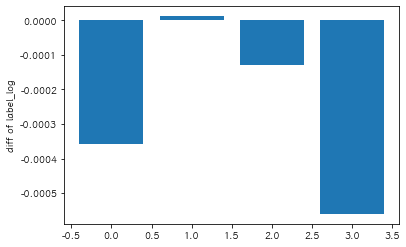

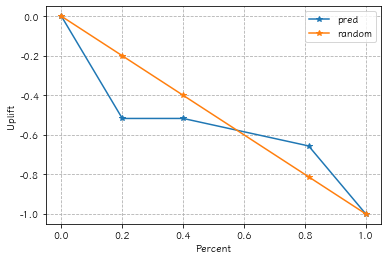

[I 2023-04-22 07:35:36,319] Trial 11 finished with value: -0.05238561529260727 and parameters: {'epochs': 40, 'shared_hidden': 274, 'outcome_hidden': 149, 'learning_rate': 0.0006547872827516483, 'alpha': 0.861334607343075, 'beta': 0.763846480299527}. Best is trial 4 with value: 0.4783368169532736.


auuc score: -0.05238561529260727 random score: 0.49999915471117606
spearmanr: 0.39999999999999997
epochs: 40
shared_hidden: 194
outcome_hidden: 125
learning_rate: 0.0006162226440735274
alpha: 0.961083470414034
beta: 0.7042124567790606
epoch: 0--------- train_loss: 1295402532864.0
epoch: 1--------- train_loss: 59933929472.0
epoch: 2--------- train_loss: 6360477184.0
epoch: 3--------- train_loss: 17898020864.0
epoch: 4--------- train_loss: 12609167360.0
epoch: 5--------- train_loss: 11961469952.0
epoch: 6--------- train_loss: 4358830592.0
epoch: 7--------- train_loss: 1953319296.0
epoch: 8--------- train_loss: 1648157952.0
epoch: 9--------- train_loss: 1326429440.0
epoch: 10--------- train_loss: 7622848512.0
epoch: 11--------- train_loss: 2774623232.0
epoch: 12--------- train_loss: 225893810176.0
epoch: 13--------- train_loss: 23931822080.0
epoch: 14--------- train_loss: 1685269376.0
epoch: 15--------- train_loss: 892598272.0
epoch: 16--------- train_loss: 793448704.0
epoch: 17--------- 

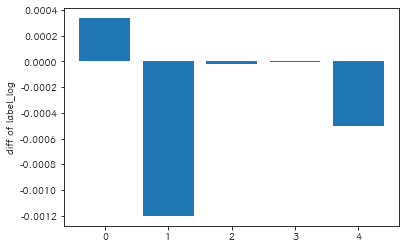

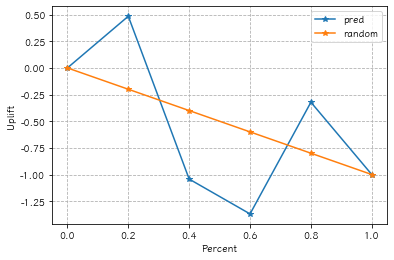

[I 2023-04-22 08:01:54,319] Trial 12 finished with value: -0.04979417546557918 and parameters: {'epochs': 40, 'shared_hidden': 194, 'outcome_hidden': 125, 'learning_rate': 0.0006162226440735274, 'alpha': 0.961083470414034, 'beta': 0.7042124567790606}. Best is trial 4 with value: 0.4783368169532736.


auuc score: -0.04979417546557918 random score: 0.5000000950217497
spearmanr: 0.3
epochs: 70
shared_hidden: 271
outcome_hidden: 72
learning_rate: 0.0005026778947617791
alpha: 0.8747858526477622
beta: 0.8504235180452221
epoch: 0--------- train_loss: 2541053542400.0
epoch: 1--------- train_loss: 1246817943552.0
epoch: 2--------- train_loss: 181071396864.0
epoch: 3--------- train_loss: 33242259456.0
epoch: 4--------- train_loss: 44245311488.0
epoch: 5--------- train_loss: 1277773184.0
epoch: 6--------- train_loss: 1126376704.0
epoch: 7--------- train_loss: 574311680.0
epoch: 8--------- train_loss: 436915808.0
epoch: 9--------- train_loss: 565126272.0
epoch: 10--------- train_loss: 418656384.0
epoch: 11--------- train_loss: 390594688.0
epoch: 12--------- train_loss: 354521248.0
epoch: 13--------- train_loss: 370693504.0
epoch: 14--------- train_loss: 330702816.0
epoch: 15--------- train_loss: 313949824.0
epoch: 16--------- train_loss: 291261696.0
epoch: 17--------- train_loss: 280721728.0
e

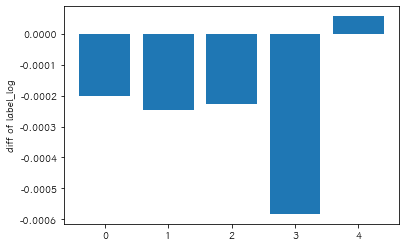

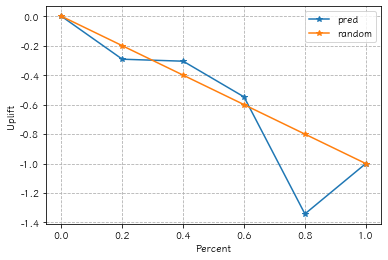

[I 2023-04-22 08:56:31,932] Trial 13 finished with value: -0.09721666453425343 and parameters: {'epochs': 70, 'shared_hidden': 271, 'outcome_hidden': 72, 'learning_rate': 0.0005026778947617791, 'alpha': 0.8747858526477622, 'beta': 0.8504235180452221}. Best is trial 4 with value: 0.4783368169532736.


auuc score: -0.09721666453425343 random score: 0.4999994706664131
spearmanr: -0.09999999999999999
epochs: 57
shared_hidden: 224
outcome_hidden: 109
learning_rate: 0.000754184336962532
alpha: 0.9952156522321446
beta: 0.7126227332267161
epoch: 0--------- train_loss: 122334838784.0
epoch: 1--------- train_loss: 17672777728.0
epoch: 2--------- train_loss: 12675799040.0
epoch: 3--------- train_loss: 1579244032.0
epoch: 4--------- train_loss: 709620736.0
epoch: 5--------- train_loss: 277134376960.0
epoch: 6--------- train_loss: 593506816.0
epoch: 7--------- train_loss: 491452416.0
epoch: 8--------- train_loss: 366828480.0
epoch: 9--------- train_loss: 305415584.0
epoch: 10--------- train_loss: 261037056.0
epoch: 11--------- train_loss: 236373216.0
epoch: 12--------- train_loss: 249644992.0
epoch: 13--------- train_loss: 313213344.0
epoch: 14--------- train_loss: 390307776.0
epoch: 15--------- train_loss: 555710848.0
epoch: 16--------- train_loss: 17799766016.0
epoch: 17--------- train_loss: 

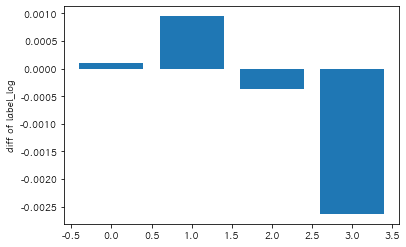

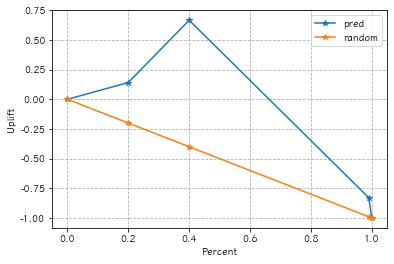

[I 2023-04-22 09:36:12,591] Trial 14 finished with value: 0.5378527940423111 and parameters: {'epochs': 57, 'shared_hidden': 224, 'outcome_hidden': 109, 'learning_rate': 0.000754184336962532, 'alpha': 0.9952156522321446, 'beta': 0.7126227332267161}. Best is trial 14 with value: 0.5378527940423111.


auuc score: 0.5378527940423111 random score: 0.5000006692132065
spearmanr: 0.7999999999999999
epochs: 58
shared_hidden: 178
outcome_hidden: 104
learning_rate: 0.0008034554724640019
alpha: 0.5111085353776307
beta: 0.7108940024667358
epoch: 0--------- train_loss: 11195289436160.0
epoch: 1--------- train_loss: 35824746496.0
epoch: 2--------- train_loss: 3578399744.0
epoch: 3--------- train_loss: 2781697024.0
epoch: 4--------- train_loss: 2030100480.0
epoch: 5--------- train_loss: 2382960896.0
epoch: 6--------- train_loss: 34023936000.0
epoch: 7--------- train_loss: 223277121536.0
epoch: 8--------- train_loss: 468605206528.0
epoch: 9--------- train_loss: 7053179904.0
epoch: 10--------- train_loss: 11747506176.0
epoch: 11--------- train_loss: 3506963456.0
epoch: 12--------- train_loss: 5958180352.0
epoch: 13--------- train_loss: 1583860992.0
epoch: 14--------- train_loss: 1223241728.0
epoch: 15--------- train_loss: 973462400.0
epoch: 16--------- train_loss: 1005982592.0
epoch: 17--------- t

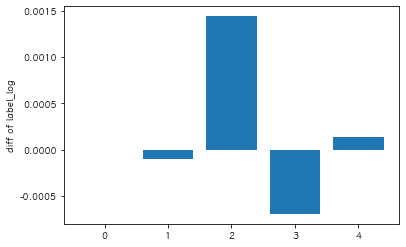

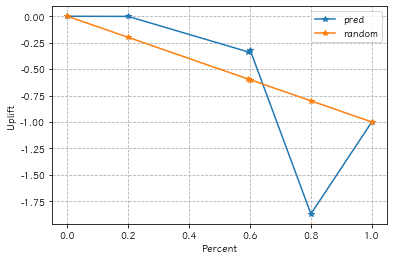

[I 2023-04-22 10:11:35,316] Trial 15 finished with value: -0.07459590886978956 and parameters: {'epochs': 58, 'shared_hidden': 178, 'outcome_hidden': 104, 'learning_rate': 0.0008034554724640019, 'alpha': 0.5111085353776307, 'beta': 0.7108940024667358}. Best is trial 14 with value: 0.5378527940423111.


auuc score: -0.07459590886978956 random score: 0.500000323536959
spearmanr: -0.09999999999999999
epochs: 53
shared_hidden: 227
outcome_hidden: 77
learning_rate: 0.000746612051073569
alpha: 0.8240673674811714
beta: 0.5772319691625822
epoch: 0--------- train_loss: 152660312064.0
epoch: 1--------- train_loss: 1752726503424.0
epoch: 2--------- train_loss: 359951630336.0
epoch: 3--------- train_loss: 228488790016.0
epoch: 4--------- train_loss: 129393688576.0
epoch: 5--------- train_loss: 1238220672.0
epoch: 6--------- train_loss: 74775994368.0
epoch: 7--------- train_loss: 567596736.0
epoch: 8--------- train_loss: 347106432.0
epoch: 9--------- train_loss: 1068762176.0
epoch: 10--------- train_loss: 984728576.0
epoch: 11--------- train_loss: 2087363584.0
epoch: 12--------- train_loss: 126507843584.0
epoch: 13--------- train_loss: 3835675136.0
epoch: 14--------- train_loss: 903259520.0
epoch: 15--------- train_loss: 380292288.0
epoch: 16--------- train_loss: 173462160.0
epoch: 17--------- tr

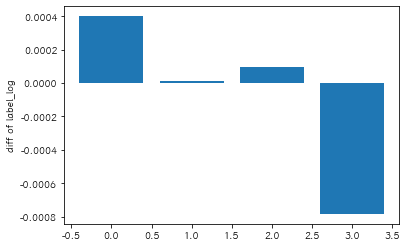

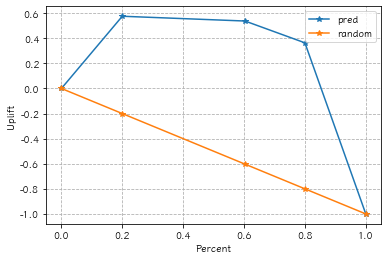

[I 2023-04-22 10:47:09,902] Trial 16 finished with value: 0.8071952313921091 and parameters: {'epochs': 53, 'shared_hidden': 227, 'outcome_hidden': 77, 'learning_rate': 0.000746612051073569, 'alpha': 0.8240673674811714, 'beta': 0.5772319691625822}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.8071952313921091 random score: 0.4999998647494439
spearmanr: 0.7999999999999999
epochs: 53
shared_hidden: 229
outcome_hidden: 75
learning_rate: 0.0007795550004281483
alpha: 0.9191678303981132
beta: 0.6958004070881487
epoch: 0--------- train_loss: 275021922304.0
epoch: 1--------- train_loss: 15639416832.0
epoch: 2--------- train_loss: 2954532096.0
epoch: 3--------- train_loss: 10604356608.0
epoch: 4--------- train_loss: 2455953152.0
epoch: 5--------- train_loss: 4853920768.0
epoch: 6--------- train_loss: 311948312576.0
epoch: 7--------- train_loss: 37981560832.0
epoch: 8--------- train_loss: 3587232256.0
epoch: 9--------- train_loss: 1758973184.0
epoch: 10--------- train_loss: 2231039488.0
epoch: 11--------- train_loss: 3858262528.0
epoch: 12--------- train_loss: 36317339648.0
epoch: 13--------- train_loss: 217314525184.0
epoch: 14--------- train_loss: 2906243840.0
epoch: 15--------- train_loss: 2122236928.0
epoch: 16--------- train_loss: 799388800.0
epoch: 17--------- tra

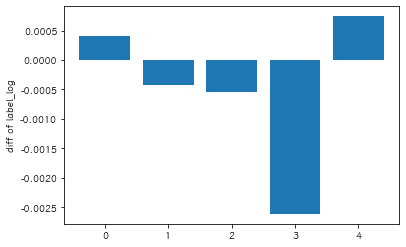

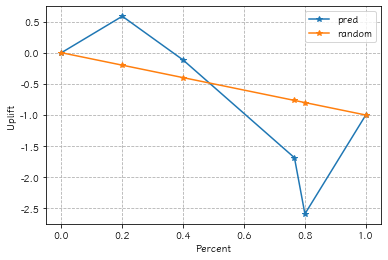

[I 2023-04-22 11:21:54,511] Trial 17 finished with value: -0.15640363421169934 and parameters: {'epochs': 53, 'shared_hidden': 229, 'outcome_hidden': 75, 'learning_rate': 0.0007795550004281483, 'alpha': 0.9191678303981132, 'beta': 0.6958004070881487}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.15640363421169934 random score: 0.500000142886691
spearmanr: -0.0
epochs: 54
shared_hidden: 166
outcome_hidden: 82
learning_rate: 0.0008782503786097354
alpha: 0.8219269763638724
beta: 0.5877855589640802
epoch: 0--------- train_loss: 958217584640.0
epoch: 1--------- train_loss: 537446252544.0
epoch: 2--------- train_loss: 7042628608.0
epoch: 3--------- train_loss: 85687738368.0
epoch: 4--------- train_loss: 873908928512.0
epoch: 5--------- train_loss: 5081320448.0
epoch: 6--------- train_loss: 1562193152.0
epoch: 7--------- train_loss: 1237390336.0
epoch: 8--------- train_loss: 1597551616.0
epoch: 9--------- train_loss: 1259737088.0
epoch: 10--------- train_loss: 1686745856.0
epoch: 11--------- train_loss: 1948722688.0
epoch: 12--------- train_loss: 2630947840.0
epoch: 13--------- train_loss: 1668281728.0
epoch: 14--------- train_loss: 1569276544.0
epoch: 15--------- train_loss: 1424883712.0
epoch: 16--------- train_loss: 1331650816.0
epoch: 17--------- train_loss: 124404

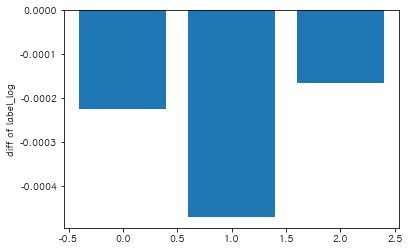

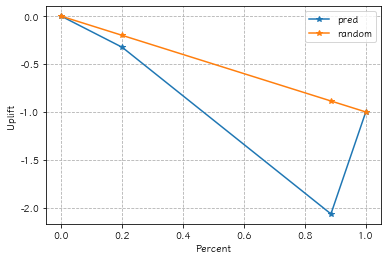

[I 2023-04-22 11:53:52,891] Trial 18 finished with value: -0.5272980934388799 and parameters: {'epochs': 54, 'shared_hidden': 166, 'outcome_hidden': 82, 'learning_rate': 0.0008782503786097354, 'alpha': 0.8219269763638724, 'beta': 0.5877855589640802}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.5272980934388799 random score: 0.5000000748052165
spearmanr: -0.5
epochs: 50
shared_hidden: 215
outcome_hidden: 102
learning_rate: 0.0007503053329690424
alpha: 0.9129293994604476
beta: 0.5110245326920045
epoch: 0--------- train_loss: 2051489398784.0
epoch: 1--------- train_loss: 376614027264.0
epoch: 2--------- train_loss: 69446860800.0
epoch: 3--------- train_loss: 43641569280.0
epoch: 4--------- train_loss: 5816555520.0
epoch: 5--------- train_loss: 2313556480.0
epoch: 6--------- train_loss: 1786904320.0
epoch: 7--------- train_loss: 1542593536.0
epoch: 8--------- train_loss: 1397087232.0
epoch: 9--------- train_loss: 1185928320.0
epoch: 10--------- train_loss: 1204777728.0
epoch: 11--------- train_loss: 513689024.0
epoch: 12--------- train_loss: 1248051840.0
epoch: 13--------- train_loss: 11936558080.0
epoch: 14--------- train_loss: 67491258368.0
epoch: 15--------- train_loss: 3870574592.0
epoch: 16--------- train_loss: 741531008.0
epoch: 17--------- train_loss: 55424

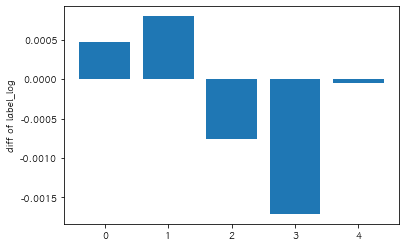

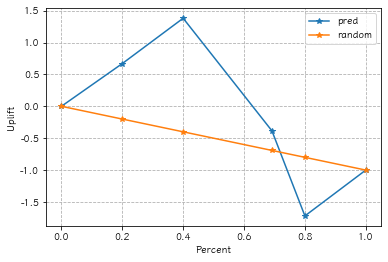

[I 2023-04-22 12:29:06,030] Trial 19 finished with value: 0.5315321402394065 and parameters: {'epochs': 50, 'shared_hidden': 215, 'outcome_hidden': 102, 'learning_rate': 0.0007503053329690424, 'alpha': 0.9129293994604476, 'beta': 0.5110245326920045}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.5315321402394065 random score: 0.4999987179892488
spearmanr: 0.6
epochs: 59
shared_hidden: 192
outcome_hidden: 131
learning_rate: 0.0009811244219732635
alpha: 0.8032374839825389
beta: 0.6661338835197138
epoch: 0--------- train_loss: 16408906825728.0
epoch: 1--------- train_loss: 147774504960.0
epoch: 2--------- train_loss: 211308199936.0
epoch: 3--------- train_loss: 4432373760.0
epoch: 4--------- train_loss: 2906261504.0
epoch: 5--------- train_loss: 2032277504.0
epoch: 6--------- train_loss: 962176896.0
epoch: 7--------- train_loss: 807361408.0
epoch: 8--------- train_loss: 7390801408.0
epoch: 9--------- train_loss: 848374016.0
epoch: 10--------- train_loss: 1492589824.0
epoch: 11--------- train_loss: 1731561984.0
epoch: 12--------- train_loss: 3727831040.0
epoch: 13--------- train_loss: 7018537984.0
epoch: 14--------- train_loss: 18835247104.0
epoch: 15--------- train_loss: 156519596032.0
epoch: 16--------- train_loss: 22466080768.0
epoch: 17--------- train_loss: 78897

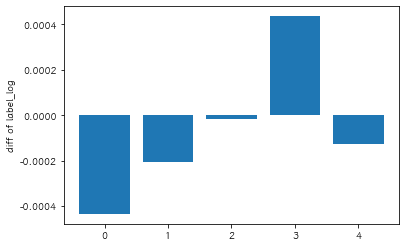

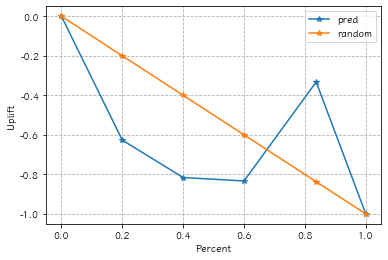

[I 2023-04-22 13:07:50,013] Trial 20 finished with value: -0.11858118720790584 and parameters: {'epochs': 59, 'shared_hidden': 192, 'outcome_hidden': 131, 'learning_rate': 0.0009811244219732635, 'alpha': 0.8032374839825389, 'beta': 0.6661338835197138}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.11858118720790584 random score: 0.5000018986491568
spearmanr: -0.7
epochs: 51
shared_hidden: 212
outcome_hidden: 105
learning_rate: 0.0007513341673150267
alpha: 0.9091267963010672
beta: 0.5088621036264565
epoch: 0--------- train_loss: 1486778138624.0
epoch: 1--------- train_loss: 119150673920.0
epoch: 2--------- train_loss: 104730705920.0
epoch: 3--------- train_loss: 4778467328.0
epoch: 4--------- train_loss: 735005704192.0
epoch: 5--------- train_loss: 13513696256.0
epoch: 6--------- train_loss: 28214931456.0
epoch: 7--------- train_loss: 1122251264.0
epoch: 8--------- train_loss: 832279744.0
epoch: 9--------- train_loss: 921644416.0
epoch: 10--------- train_loss: 2106956544.0
epoch: 11--------- train_loss: 637233664.0
epoch: 12--------- train_loss: 705943104.0
epoch: 13--------- train_loss: 681340032.0
epoch: 14--------- train_loss: 909456256.0
epoch: 15--------- train_loss: 820302464.0
epoch: 16--------- train_loss: 1020334720.0
epoch: 17--------- train_loss: 5870380

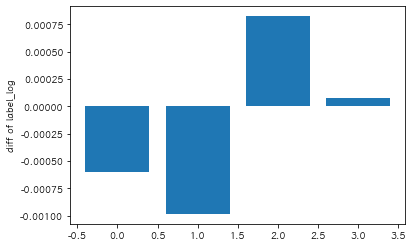

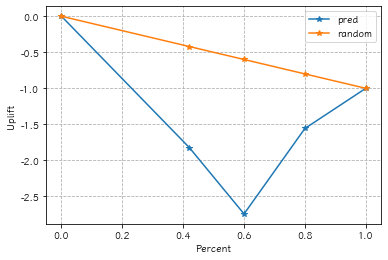

[I 2023-04-22 13:45:21,833] Trial 21 finished with value: -0.9785473480873371 and parameters: {'epochs': 51, 'shared_hidden': 212, 'outcome_hidden': 105, 'learning_rate': 0.0007513341673150267, 'alpha': 0.9091267963010672, 'beta': 0.5088621036264565}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.9785473480873371 random score: 0.4999990658294067
spearmanr: -0.6000000000000001
epochs: 50
shared_hidden: 230
outcome_hidden: 99
learning_rate: 0.000748008857904133
alpha: 0.9399125886268416
beta: 0.5794231450827094
epoch: 0--------- train_loss: 1606474530816.0
epoch: 1--------- train_loss: 3076435476480.0
epoch: 2--------- train_loss: 11706956800.0
epoch: 3--------- train_loss: 15614373888.0
epoch: 4--------- train_loss: 4230488320.0
epoch: 5--------- train_loss: 1363685120.0
epoch: 6--------- train_loss: 32650792960.0
epoch: 7--------- train_loss: 2400663552.0
epoch: 8--------- train_loss: 1183538304.0
epoch: 9--------- train_loss: 730013056.0
epoch: 10--------- train_loss: 576884992.0
epoch: 11--------- train_loss: 707452224.0
epoch: 12--------- train_loss: 667564224.0
epoch: 13--------- train_loss: 983559936.0
epoch: 14--------- train_loss: 1341808000.0
epoch: 15--------- train_loss: 719979520.0
epoch: 16--------- train_loss: 627901952.0
epoch: 17--------- train_los

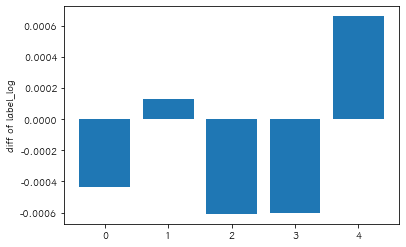

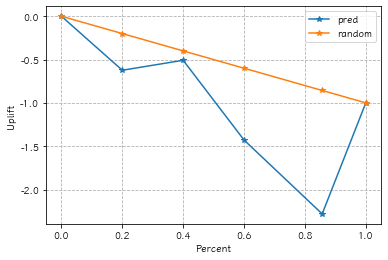

[I 2023-04-22 14:21:48,027] Trial 22 finished with value: -0.5805448095479818 and parameters: {'epochs': 50, 'shared_hidden': 230, 'outcome_hidden': 99, 'learning_rate': 0.000748008857904133, 'alpha': 0.9399125886268416, 'beta': 0.5794231450827094}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.5805448095479818 random score: 0.5000012145213355
spearmanr: -0.19999999999999998
epochs: 55
shared_hidden: 108
outcome_hidden: 110
learning_rate: 0.0008518547156789165
alpha: 0.8899224100851317
beta: 0.6010486968918104
epoch: 0--------- train_loss: 21939222528.0
epoch: 1--------- train_loss: 661071724544.0
epoch: 2--------- train_loss: 844392169472.0
epoch: 3--------- train_loss: 25498124288.0
epoch: 4--------- train_loss: 134865207296.0
epoch: 5--------- train_loss: 53958688768.0
epoch: 6--------- train_loss: 8854876160.0
epoch: 7--------- train_loss: 6492610048.0
epoch: 8--------- train_loss: 6307529728.0
epoch: 9--------- train_loss: 3951988736.0
epoch: 10--------- train_loss: 4248509952.0
epoch: 11--------- train_loss: 3115654144.0
epoch: 12--------- train_loss: 3532160512.0
epoch: 13--------- train_loss: 3237890048.0
epoch: 14--------- train_loss: 2570201600.0
epoch: 15--------- train_loss: 2193670656.0
epoch: 16--------- train_loss: 1798575872.0
epoch: 17---------

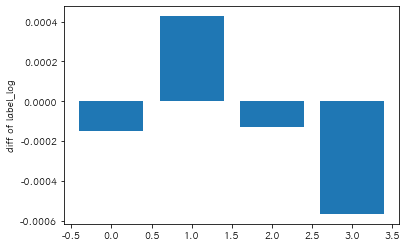

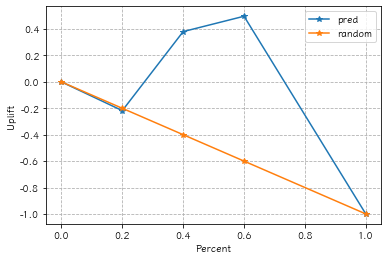

[I 2023-04-22 14:52:37,945] Trial 23 finished with value: 0.4817418063117721 and parameters: {'epochs': 55, 'shared_hidden': 108, 'outcome_hidden': 110, 'learning_rate': 0.0008518547156789165, 'alpha': 0.8899224100851317, 'beta': 0.6010486968918104}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.4817418063117721 random score: 0.5000000410406951
spearmanr: 0.39999999999999997
epochs: 45
shared_hidden: 233
outcome_hidden: 96
learning_rate: 0.0007117575018465519
alpha: 0.9648159037997895
beta: 0.538847631742162
epoch: 0--------- train_loss: 4050788810752.0
epoch: 1--------- train_loss: 957758177280.0
epoch: 2--------- train_loss: 6618248904704.0
epoch: 3--------- train_loss: 70592757760.0
epoch: 4--------- train_loss: 1934347776.0
epoch: 5--------- train_loss: 4448152064.0
epoch: 6--------- train_loss: 12480660480.0
epoch: 7--------- train_loss: 40350146560.0
epoch: 8--------- train_loss: 2306188800.0
epoch: 9--------- train_loss: 1854774656.0
epoch: 10--------- train_loss: 1902742912.0
epoch: 11--------- train_loss: 1387042688.0
epoch: 12--------- train_loss: 1183402368.0
epoch: 13--------- train_loss: 1188547328.0
epoch: 14--------- train_loss: 1165072384.0
epoch: 15--------- train_loss: 2820087040.0
epoch: 16--------- train_loss: 1379364096.0
epoch: 17--------- t

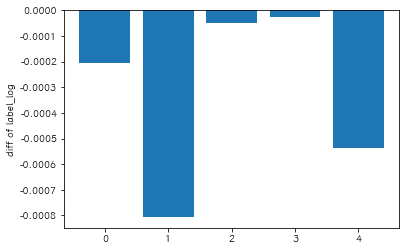

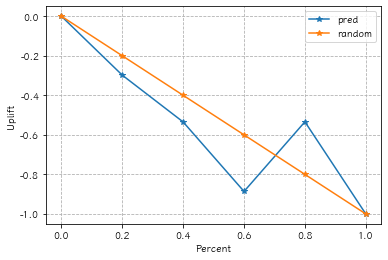

[I 2023-04-22 15:26:36,484] Trial 24 finished with value: -0.050625139949180775 and parameters: {'epochs': 45, 'shared_hidden': 233, 'outcome_hidden': 96, 'learning_rate': 0.0007117575018465519, 'alpha': 0.9648159037997895, 'beta': 0.538847631742162}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.050625139949180775 random score: 0.5000007283959313
spearmanr: -0.19999999999999998
epochs: 57
shared_hidden: 211
outcome_hidden: 84
learning_rate: 0.0008954804079894177
alpha: 0.8969967416256713
beta: 0.61257866324512
epoch: 0--------- train_loss: 5487774924800.0
epoch: 1--------- train_loss: 30701355008.0
epoch: 2--------- train_loss: 8781220864.0
epoch: 3--------- train_loss: 4792066048.0
epoch: 4--------- train_loss: 1964823808.0
epoch: 5--------- train_loss: 4263005696.0
epoch: 6--------- train_loss: 1826958720.0
epoch: 7--------- train_loss: 2489906176.0
epoch: 8--------- train_loss: 42753548288.0
epoch: 9--------- train_loss: 5680216064.0
epoch: 10--------- train_loss: 6837896192.0
epoch: 11--------- train_loss: 3372885248.0
epoch: 12--------- train_loss: 1757828608.0
epoch: 13--------- train_loss: 1701692672.0
epoch: 14--------- train_loss: 1443185664.0
epoch: 15--------- train_loss: 2830761984.0
epoch: 16--------- train_loss: 21802717184.0
epoch: 17--------- tra

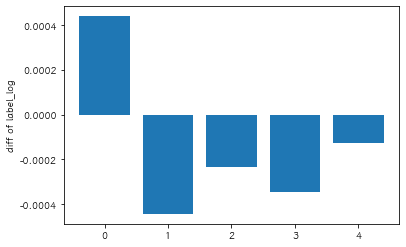

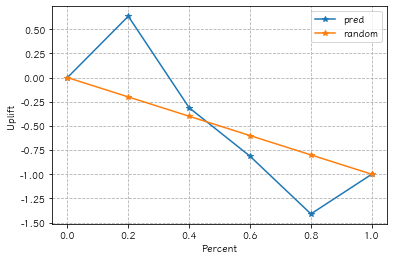

[I 2023-04-22 16:08:49,856] Trial 25 finished with value: 0.019616001491487456 and parameters: {'epochs': 57, 'shared_hidden': 211, 'outcome_hidden': 84, 'learning_rate': 0.0008954804079894177, 'alpha': 0.8969967416256713, 'beta': 0.61257866324512}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.019616001491487456 random score: 0.500002263561309
spearmanr: 0.09999999999999999
epochs: 53
shared_hidden: 178
outcome_hidden: 112
learning_rate: 0.0007815610320484542
alpha: 0.9505069793508361
beta: 0.5409335529248775
epoch: 0--------- train_loss: 3355745189888.0
epoch: 1--------- train_loss: 268722241536.0
epoch: 2--------- train_loss: 256205422592.0
epoch: 3--------- train_loss: 3670447616.0
epoch: 4--------- train_loss: 1324748672.0
epoch: 5--------- train_loss: 1087984512.0
epoch: 6--------- train_loss: 928499456.0
epoch: 7--------- train_loss: 831068544.0
epoch: 8--------- train_loss: 1079877888.0
epoch: 9--------- train_loss: 894392448.0
epoch: 10--------- train_loss: 840397056.0
epoch: 11--------- train_loss: 847816832.0
epoch: 12--------- train_loss: 762008192.0
epoch: 13--------- train_loss: 826136448.0
epoch: 14--------- train_loss: 488300288.0
epoch: 15--------- train_loss: 556474688.0
epoch: 16--------- train_loss: 431690944.0
epoch: 17--------- train_loss: 

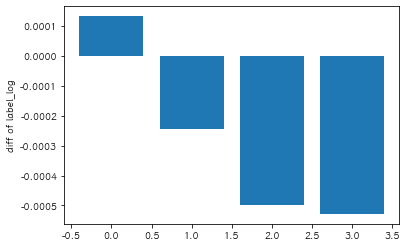

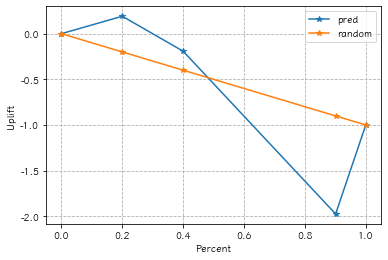

[I 2023-04-22 16:42:28,928] Trial 26 finished with value: -0.17101779130828276 and parameters: {'epochs': 53, 'shared_hidden': 178, 'outcome_hidden': 112, 'learning_rate': 0.0007815610320484542, 'alpha': 0.9505069793508361, 'beta': 0.5409335529248775}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.17101779130828276 random score: 0.5000000906550398
spearmanr: 1.0
epochs: 62
shared_hidden: 222
outcome_hidden: 79
learning_rate: 0.0005831944693118993
alpha: 0.8520514481999701
beta: 0.6664103474224128
epoch: 0--------- train_loss: 69607805157376.0
epoch: 1--------- train_loss: 3305158213632.0
epoch: 2--------- train_loss: 122955612160.0
epoch: 3--------- train_loss: 3190690304.0
epoch: 4--------- train_loss: 7789854720.0
epoch: 5--------- train_loss: 6046220288.0
epoch: 6--------- train_loss: 2089803392.0
epoch: 7--------- train_loss: 1027337920.0
epoch: 8--------- train_loss: 1002559744.0
epoch: 9--------- train_loss: 3567424768.0
epoch: 10--------- train_loss: 601804608.0
epoch: 11--------- train_loss: 396835200.0
epoch: 12--------- train_loss: 1987168256.0
epoch: 13--------- train_loss: 722515008.0
epoch: 14--------- train_loss: 1028876544.0
epoch: 15--------- train_loss: 6419808256.0
epoch: 16--------- train_loss: 387887424.0
epoch: 17--------- train_loss: 34387923

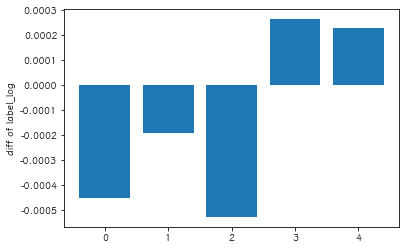

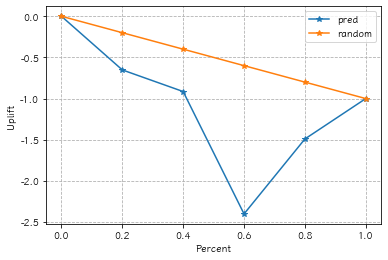

[I 2023-04-22 17:29:42,745] Trial 27 finished with value: -0.6915601823722859 and parameters: {'epochs': 62, 'shared_hidden': 222, 'outcome_hidden': 79, 'learning_rate': 0.0005831944693118993, 'alpha': 0.8520514481999701, 'beta': 0.6664103474224128}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.6915601823722859 random score: 0.499999955139784
spearmanr: -0.6
epochs: 49
shared_hidden: 240
outcome_hidden: 95
learning_rate: 0.0007105031327428157
alpha: 0.8881751028389123
beta: 0.5836163734634678
epoch: 0--------- train_loss: 16074488676352.0
epoch: 1--------- train_loss: 532342407168.0
epoch: 2--------- train_loss: 195949576192.0
epoch: 3--------- train_loss: 14053289984.0
epoch: 4--------- train_loss: 3101315840.0
epoch: 5--------- train_loss: 1514149632.0
epoch: 6--------- train_loss: 1654442496.0
epoch: 7--------- train_loss: 826557568.0
epoch: 8--------- train_loss: 827087872.0
epoch: 9--------- train_loss: 1130358912.0
epoch: 10--------- train_loss: 1437609856.0
epoch: 11--------- train_loss: 3965632512.0
epoch: 12--------- train_loss: 4203055616.0
epoch: 13--------- train_loss: 32757485568.0
epoch: 14--------- train_loss: 3930193152.0
epoch: 15--------- train_loss: 841409600.0
epoch: 16--------- train_loss: 465850880.0
epoch: 17--------- train_loss: 42516307

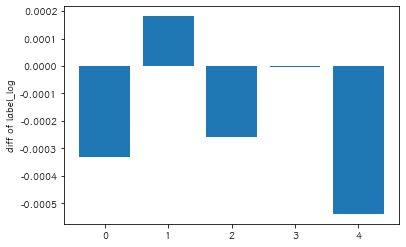

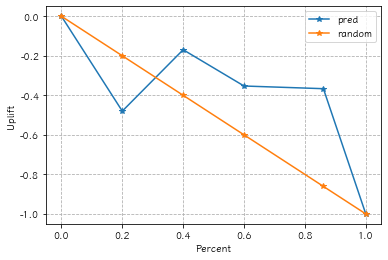

[I 2023-04-22 18:06:04,837] Trial 28 finished with value: 0.1458785220320638 and parameters: {'epochs': 49, 'shared_hidden': 240, 'outcome_hidden': 95, 'learning_rate': 0.0007105031327428157, 'alpha': 0.8881751028389123, 'beta': 0.5836163734634678}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.1458785220320638 random score: 0.4999978842469865
spearmanr: 0.3
epochs: 61
shared_hidden: 257
outcome_hidden: 132
learning_rate: 0.0008331868664369288
alpha: 0.7959415205559018
beta: 0.5024562097356653
epoch: 0--------- train_loss: 7510621683712.0
epoch: 1--------- train_loss: 22460932096.0
epoch: 2--------- train_loss: 197708185600.0
epoch: 3--------- train_loss: 5652692480.0
epoch: 4--------- train_loss: 6571533312.0
epoch: 5--------- train_loss: 5070523904.0
epoch: 6--------- train_loss: 1313245696.0
epoch: 7--------- train_loss: 2089351168.0
epoch: 8--------- train_loss: 653705344.0
epoch: 9--------- train_loss: 709269056.0
epoch: 10--------- train_loss: 624153984.0
epoch: 11--------- train_loss: 347936576.0
epoch: 12--------- train_loss: 6770872320.0
epoch: 13--------- train_loss: 911840768.0
epoch: 14--------- train_loss: 12366814208.0
epoch: 15--------- train_loss: 105452044288.0
epoch: 16--------- train_loss: 808537216.0
epoch: 17--------- train_loss: 489965824.0

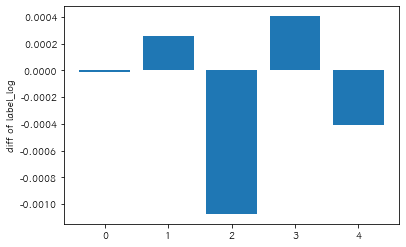

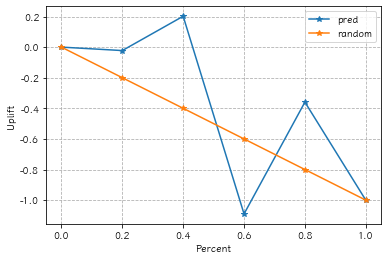

[I 2023-04-22 18:55:17,395] Trial 29 finished with value: 0.14592814498740714 and parameters: {'epochs': 61, 'shared_hidden': 257, 'outcome_hidden': 132, 'learning_rate': 0.0008331868664369288, 'alpha': 0.7959415205559018, 'beta': 0.5024562097356653}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.14592814498740714 random score: 0.5000000743063266
spearmanr: 0.09999999999999999
epochs: 44
shared_hidden: 199
outcome_hidden: 103
learning_rate: 0.0009278696907783269
alpha: 0.9745487178322962
beta: 0.6368645616848764
epoch: 0--------- train_loss: 6218742497280.0
epoch: 1--------- train_loss: 866147631104.0
epoch: 2--------- train_loss: 4995082240.0
epoch: 3--------- train_loss: 11684603904.0
epoch: 4--------- train_loss: 1883420288.0
epoch: 5--------- train_loss: 1374263168.0
epoch: 6--------- train_loss: 2227113472.0
epoch: 7--------- train_loss: 1592793856.0
epoch: 8--------- train_loss: 1722408960.0
epoch: 9--------- train_loss: 1292882944.0
epoch: 10--------- train_loss: 1191880448.0
epoch: 11--------- train_loss: 1270517504.0
epoch: 12--------- train_loss: 1208808320.0
epoch: 13--------- train_loss: 4280097280.0
epoch: 14--------- train_loss: 12061162496.0
epoch: 15--------- train_loss: 89053429760.0
epoch: 16--------- train_loss: 1531395968.0
epoch: 17--------- t

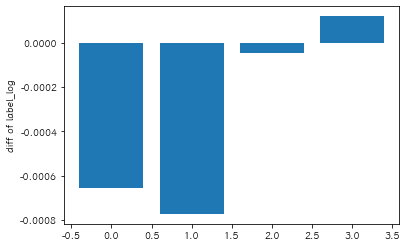

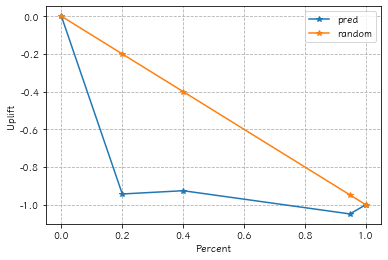

[I 2023-04-22 19:24:40,380] Trial 30 finished with value: -0.3754879846432284 and parameters: {'epochs': 44, 'shared_hidden': 199, 'outcome_hidden': 103, 'learning_rate': 0.0009278696907783269, 'alpha': 0.9745487178322962, 'beta': 0.6368645616848764}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.3754879846432284 random score: 0.500001969664606
spearmanr: -0.7999999999999999
epochs: 55
shared_hidden: 117
outcome_hidden: 112
learning_rate: 0.0008569985620082452
alpha: 0.9083175398801471
beta: 0.6036271777324939
epoch: 0--------- train_loss: 375271915520.0
epoch: 1--------- train_loss: 22401339392.0
epoch: 2--------- train_loss: 24440152064.0
epoch: 3--------- train_loss: 16017115136.0
epoch: 4--------- train_loss: 6879050752.0
epoch: 5--------- train_loss: 2545047040.0
epoch: 6--------- train_loss: 57220370432.0
epoch: 7--------- train_loss: 11211122688.0
epoch: 8--------- train_loss: 3110123264.0
epoch: 9--------- train_loss: 2222364672.0
epoch: 10--------- train_loss: 3188122112.0
epoch: 11--------- train_loss: 2521683712.0
epoch: 12--------- train_loss: 2943515392.0
epoch: 13--------- train_loss: 13853419520.0
epoch: 14--------- train_loss: 239607545856.0
epoch: 15--------- train_loss: 6779715584.0
epoch: 16--------- train_loss: 2363745792.0
epoch: 17--------- 

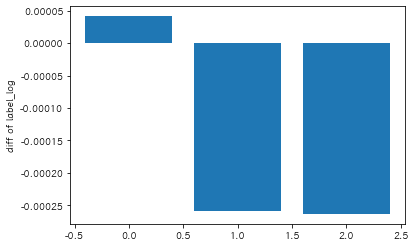

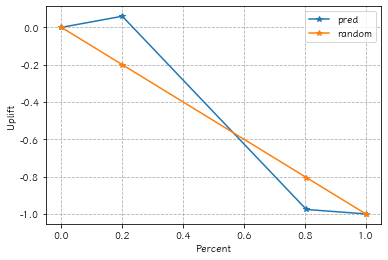

[I 2023-04-22 19:56:34,594] Trial 31 finished with value: 0.035895280896174386 and parameters: {'epochs': 55, 'shared_hidden': 117, 'outcome_hidden': 112, 'learning_rate': 0.0008569985620082452, 'alpha': 0.9083175398801471, 'beta': 0.6036271777324939}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.035895280896174386 random score: 0.4999996607100043
spearmanr: 1.0
epochs: 52
shared_hidden: 158
outcome_hidden: 110
learning_rate: 0.0008070355560440295
alpha: 0.8650506707504002
beta: 0.56011520117445
epoch: 0--------- train_loss: 1463724015616.0
epoch: 1--------- train_loss: 403928088576.0
epoch: 2--------- train_loss: 43518291968.0
epoch: 3--------- train_loss: 15183415296.0
epoch: 4--------- train_loss: 5993686528.0
epoch: 5--------- train_loss: 17239396352.0
epoch: 6--------- train_loss: 3262575360.0
epoch: 7--------- train_loss: 2073561728.0
epoch: 8--------- train_loss: 1624803840.0
epoch: 9--------- train_loss: 1604006144.0
epoch: 10--------- train_loss: 1523065472.0
epoch: 11--------- train_loss: 1357289984.0
epoch: 12--------- train_loss: 1277873664.0
epoch: 13--------- train_loss: 1560242688.0
epoch: 14--------- train_loss: 1604938496.0
epoch: 15--------- train_loss: 38141878272.0
epoch: 16--------- train_loss: 64268460032.0
epoch: 17--------- train_loss: 1763

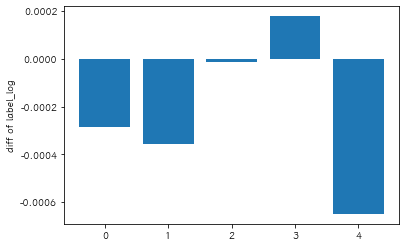

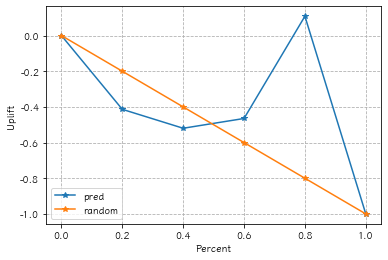

[I 2023-04-22 20:29:35,604] Trial 32 finished with value: 0.14199507911608628 and parameters: {'epochs': 52, 'shared_hidden': 158, 'outcome_hidden': 110, 'learning_rate': 0.0008070355560440295, 'alpha': 0.8650506707504002, 'beta': 0.56011520117445}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.14199507911608628 random score: 0.49999892877215885
spearmanr: 0.09999999999999999
epochs: 56
shared_hidden: 108
outcome_hidden: 119
learning_rate: 0.0007372075648848398
alpha: 0.9860217190156213
beta: 0.6052145535287929
epoch: 0--------- train_loss: 14637623296.0
epoch: 1--------- train_loss: 19193933824.0
epoch: 2--------- train_loss: 10456824832.0
epoch: 3--------- train_loss: 7332988928.0
epoch: 4--------- train_loss: 4025522432.0
epoch: 5--------- train_loss: 3179758592.0
epoch: 6--------- train_loss: 2477935616.0
epoch: 7--------- train_loss: 2084567296.0
epoch: 8--------- train_loss: 3438515200.0
epoch: 9--------- train_loss: 2441628160.0
epoch: 10--------- train_loss: 4245285888.0
epoch: 11--------- train_loss: 5370632192.0
epoch: 12--------- train_loss: 24834859008.0
epoch: 13--------- train_loss: 17639878656.0
epoch: 14--------- train_loss: 27539625984.0
epoch: 15--------- train_loss: 406991175680.0
epoch: 16--------- train_loss: 62797594624.0
epoch: 17---------

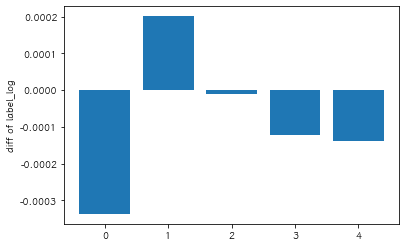

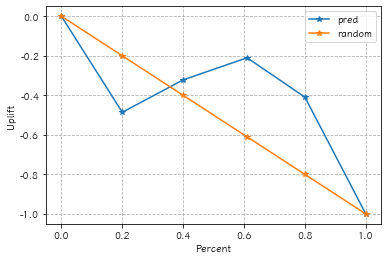

[I 2023-04-22 21:01:56,615] Trial 33 finished with value: 0.11501909587558734 and parameters: {'epochs': 56, 'shared_hidden': 108, 'outcome_hidden': 119, 'learning_rate': 0.0007372075648848398, 'alpha': 0.9860217190156213, 'beta': 0.6052145535287929}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.11501909587558734 random score: 0.5000009829629772
spearmanr: -0.0
epochs: 58
shared_hidden: 138
outcome_hidden: 92
learning_rate: 0.0009300830141368503
alpha: 0.9991738884994161
beta: 0.5238897697876168
epoch: 0--------- train_loss: 2813592862720.0
epoch: 1--------- train_loss: 1089262190592.0
epoch: 2--------- train_loss: 73268305920.0
epoch: 3--------- train_loss: 3704629248.0
epoch: 4--------- train_loss: 2344432896.0
epoch: 5--------- train_loss: 1888801280.0
epoch: 6--------- train_loss: 3381542912.0
epoch: 7--------- train_loss: 1840044416.0
epoch: 8--------- train_loss: 1250994944.0
epoch: 9--------- train_loss: 1016509248.0
epoch: 10--------- train_loss: 1083323392.0
epoch: 11--------- train_loss: 1254172288.0
epoch: 12--------- train_loss: 4367152640.0
epoch: 13--------- train_loss: 4718714368.0
epoch: 14--------- train_loss: 2573371136.0
epoch: 15--------- train_loss: 245601550336.0
epoch: 16--------- train_loss: 18595219456.0
epoch: 17--------- train_loss: 223

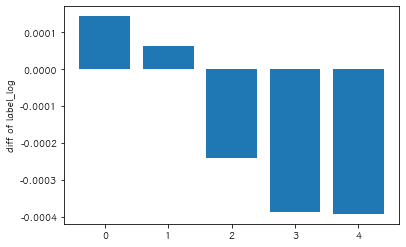

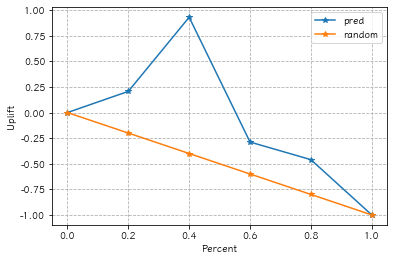

[I 2023-04-22 21:36:48,381] Trial 34 finished with value: 0.4780379730427813 and parameters: {'epochs': 58, 'shared_hidden': 138, 'outcome_hidden': 92, 'learning_rate': 0.0009300830141368503, 'alpha': 0.9991738884994161, 'beta': 0.5238897697876168}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.4780379730427813 random score: 0.4999985006269181
spearmanr: 0.9999999999999999
epochs: 54
shared_hidden: 182
outcome_hidden: 64
learning_rate: 0.0006453284841592167
alpha: 0.9354051387604451
beta: 0.5599602045872093
epoch: 0--------- train_loss: 19552406601728.0
epoch: 1--------- train_loss: 75884027904.0
epoch: 2--------- train_loss: 16093574144.0
epoch: 3--------- train_loss: 8112386560.0
epoch: 4--------- train_loss: 4651824640.0
epoch: 5--------- train_loss: 2297639936.0
epoch: 6--------- train_loss: 1502563072.0
epoch: 7--------- train_loss: 1610617088.0
epoch: 8--------- train_loss: 1295453824.0
epoch: 9--------- train_loss: 2155110144.0
epoch: 10--------- train_loss: 401847615488.0
epoch: 11--------- train_loss: 21973708800.0
epoch: 12--------- train_loss: 18972170240.0
epoch: 13--------- train_loss: 1282866176.0
epoch: 14--------- train_loss: 1187684224.0
epoch: 15--------- train_loss: 53498880000.0
epoch: 16--------- train_loss: 7749131264.0
epoch: 17--------- t

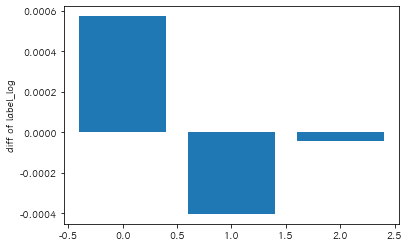

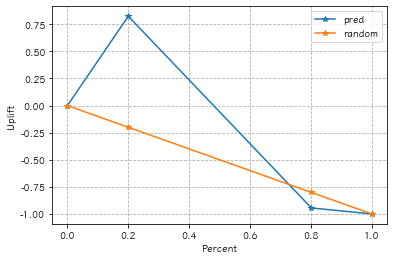

[I 2023-04-22 22:13:02,327] Trial 35 finished with value: 0.3533022950225941 and parameters: {'epochs': 54, 'shared_hidden': 182, 'outcome_hidden': 64, 'learning_rate': 0.0006453284841592167, 'alpha': 0.9354051387604451, 'beta': 0.5599602045872093}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.3533022950225941 random score: 0.499999997107117
spearmanr: 0.5
epochs: 46
shared_hidden: 244
outcome_hidden: 119
learning_rate: 0.0008532643937163602
alpha: 0.9273600583789344
beta: 0.5412648334314957
epoch: 0--------- train_loss: 20763025342464.0
epoch: 1--------- train_loss: 696622317568.0
epoch: 2--------- train_loss: 5303377920.0
epoch: 3--------- train_loss: 1991126272.0
epoch: 4--------- train_loss: 1312249216.0
epoch: 5--------- train_loss: 1248799232.0
epoch: 6--------- train_loss: 1114905856.0
epoch: 7--------- train_loss: 3299122176.0
epoch: 8--------- train_loss: 1507281152.0
epoch: 9--------- train_loss: 813573632.0
epoch: 10--------- train_loss: 763953344.0
epoch: 11--------- train_loss: 769049216.0
epoch: 12--------- train_loss: 1378028160.0
epoch: 13--------- train_loss: 19735867392.0
epoch: 14--------- train_loss: 2208295424.0
epoch: 15--------- train_loss: 1759742976.0
epoch: 16--------- train_loss: 945376064.0
epoch: 17--------- train_loss: 2526772736.0

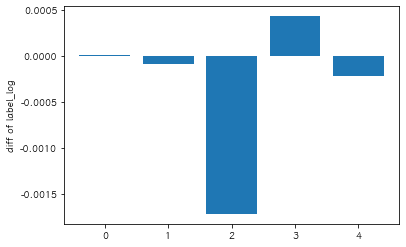

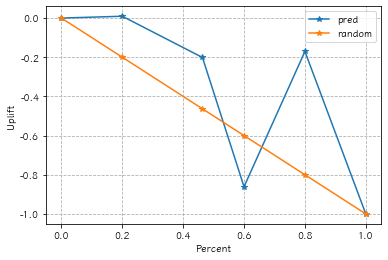

[I 2023-04-22 22:51:18,844] Trial 36 finished with value: 0.18283063088703 and parameters: {'epochs': 46, 'shared_hidden': 244, 'outcome_hidden': 119, 'learning_rate': 0.0008532643937163602, 'alpha': 0.9273600583789344, 'beta': 0.5412648334314957}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.18283063088703 random score: 0.5000001747518874
spearmanr: 0.19999999999999998
epochs: 43
shared_hidden: 204
outcome_hidden: 52
learning_rate: 0.0009754181389339305
alpha: 0.8878906688672799
beta: 0.6569040552932811
epoch: 0--------- train_loss: 6901437825024.0
epoch: 1--------- train_loss: 245468233728.0
epoch: 2--------- train_loss: 1480974008320.0
epoch: 3--------- train_loss: 12938856448.0
epoch: 4--------- train_loss: 3289934336.0
epoch: 5--------- train_loss: 2236350208.0
epoch: 6--------- train_loss: 1878580864.0
epoch: 7--------- train_loss: 1453158784.0
epoch: 8--------- train_loss: 1260563712.0
epoch: 9--------- train_loss: 1721172224.0
epoch: 10--------- train_loss: 3626538496.0
epoch: 11--------- train_loss: 22922035200.0
epoch: 12--------- train_loss: 383791267840.0
epoch: 13--------- train_loss: 1200055040.0
epoch: 14--------- train_loss: 375999168.0
epoch: 15--------- train_loss: 262474448.0
epoch: 16--------- train_loss: 257344704.0
epoch: 17--------- trai

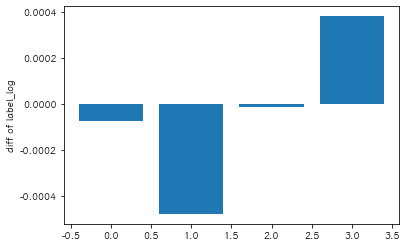

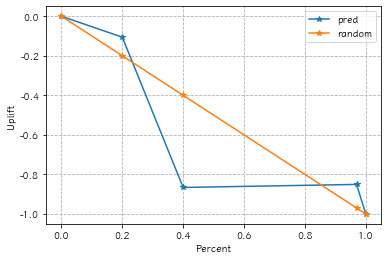

[I 2023-04-22 23:21:58,951] Trial 37 finished with value: -0.12491415185125104 and parameters: {'epochs': 43, 'shared_hidden': 204, 'outcome_hidden': 52, 'learning_rate': 0.0009754181389339305, 'alpha': 0.8878906688672799, 'beta': 0.6569040552932811}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.12491415185125104 random score: 0.5000003704290029
spearmanr: -0.7999999999999999
epochs: 49
shared_hidden: 217
outcome_hidden: 107
learning_rate: 0.0006979250832197829
alpha: 0.9602915984935225
beta: 0.5232448009215439
epoch: 0--------- train_loss: 323068526592.0
epoch: 1--------- train_loss: 91037589504.0
epoch: 2--------- train_loss: 8484950016.0
epoch: 3--------- train_loss: 18735196160.0
epoch: 4--------- train_loss: 4152936960.0
epoch: 5--------- train_loss: 1588066048.0
epoch: 6--------- train_loss: 1229252096.0
epoch: 7--------- train_loss: 1120693248.0
epoch: 8--------- train_loss: 988342912.0
epoch: 9--------- train_loss: 878141760.0
epoch: 10--------- train_loss: 550228096.0
epoch: 11--------- train_loss: 435201536.0
epoch: 12--------- train_loss: 350025152.0
epoch: 13--------- train_loss: 612387520.0
epoch: 14--------- train_loss: 494519808.0
epoch: 15--------- train_loss: 2195825664.0
epoch: 16--------- train_loss: 451208928.0
epoch: 17--------- train_loss: 

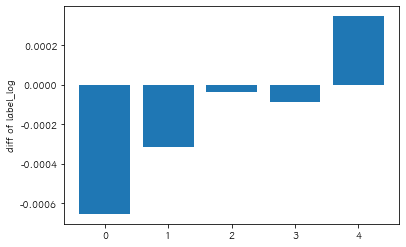

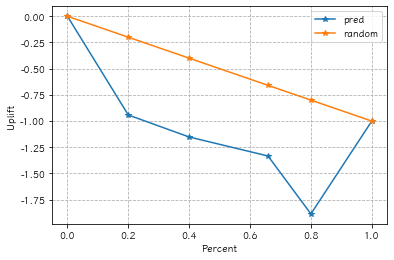

[I 2023-04-23 00:00:18,916] Trial 38 finished with value: -0.6408271519029973 and parameters: {'epochs': 49, 'shared_hidden': 217, 'outcome_hidden': 107, 'learning_rate': 0.0006979250832197829, 'alpha': 0.9602915984935225, 'beta': 0.5232448009215439}. Best is trial 16 with value: 0.8071952313921091.


auuc score: -0.6408271519029973 random score: 0.4999995532883225
spearmanr: -0.8999999999999998
epochs: 59
shared_hidden: 265
outcome_hidden: 126
learning_rate: 0.0009177852661076875
alpha: 0.9985465339852045
beta: 0.5738705380500979
epoch: 0--------- train_loss: 2453750939648.0
epoch: 1--------- train_loss: 630943449088.0
epoch: 2--------- train_loss: 8069128192.0
epoch: 3--------- train_loss: 2253022208.0
epoch: 4--------- train_loss: 898031168.0
epoch: 5--------- train_loss: 560798784.0
epoch: 6--------- train_loss: 498673728.0
epoch: 7--------- train_loss: 386394496.0
epoch: 8--------- train_loss: 1653814016.0
epoch: 9--------- train_loss: 407059808.0
epoch: 10--------- train_loss: 289229248.0
epoch: 11--------- train_loss: 328358880.0
epoch: 12--------- train_loss: 299909248.0
epoch: 13--------- train_loss: 292295872.0
epoch: 14--------- train_loss: 275728448.0
epoch: 15--------- train_loss: 345922240.0
epoch: 16--------- train_loss: 502077184.0
epoch: 17--------- train_loss: 9625

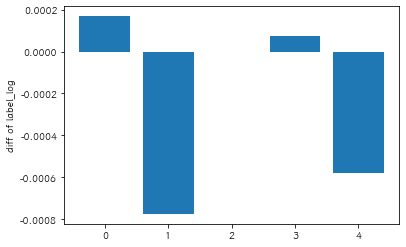

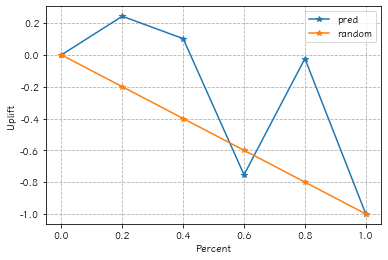

[I 2023-04-23 00:52:22,100] Trial 39 finished with value: 0.3136795533768475 and parameters: {'epochs': 59, 'shared_hidden': 265, 'outcome_hidden': 126, 'learning_rate': 0.0009177852661076875, 'alpha': 0.9985465339852045, 'beta': 0.5738705380500979}. Best is trial 16 with value: 0.8071952313921091.


auuc score: 0.3136795533768475 random score: 0.5000001902058411
spearmanr: 0.3
Study statistics: 
Number of finished trials:  40
Number of pruned trials:  0
Number of complete trials:  40
Best trial:
Value:  0.8071952313921091
Params: 
epochs: 53
shared_hidden: 227
outcome_hidden: 77
learning_rate: 0.000746612051073569
alpha: 0.8240673674811714
beta: 0.5772319691625822


In [8]:
now = datetime.now()
str_date_time = now.strftime("%d-%m-%Y_%H-%M-%S")
set_random_seed(0)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)#, callbacks=[wandbc])
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("Number of finished trials: ", len(study.trials))
print("Number of pruned trials: ", len(pruned_trials))
print("Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)

print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))

In [ ]:
print("hello")